# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:
```
!pip uninstall gym -y
!pip install gym
```

In [ ]:
# !pip install -U gym==0.25.2
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!pip install swig
!pip install gym[box2d]

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics
import torch
import os

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
def display_video(episode=0, video_width=600, video_dir= "/content/video"):

    video_path = os.path.join(video_dir, f"rl-video-episode-{episode}.mp4")
    video_file = open(video_path, "rb").read()
    decoded = b64encode(video_file).decode()
    video_url = f"data:video/mp4;base64,{decoded}"
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode=None, video_folder='/content/video'):
    # render mode: "human", "rgb_array", "ansi")
    env = gym.make(name, new_step_api=True, render_mode=render_mode)
    env = RecordVideo(env, video_folder=video_folder)
    return env

def show_reward(total_rewards):
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

## What Is a **Policy** in Reinforcement Learning?
A policy is a strategy that an agent uses in pursuit of goals. The policy dictates the actions that the agent takes as a function of the agent's state and the environment.

<br>

1. **Deterministic Policy**

In a deterministic policy, there is only one particular action possible in a given state. When the agent reaches a given state, the deterministic policy tells it to perform a particular action always.

- At any given time $t$, for a given state $s$, the deterministic policy $μ$ tells the agent to perform an action $a$. It can be expressed as:

<h1><center> $μ(s) = a$</center></h1>

2. **Stochastic Policy**

In stochastic policy, it returns a probability distribution of multiple actions in the action space for a given state. It is in contrast with the deterministic policy which always mapped a given state to only one particular action. So in this scenario, the agent may perform different actions each time it visits a particular state based on the probability distribution of actions returned by the stochastic policy.

- At any given time $t$, for a given state $s$, the deterministic policy $μ$ tells the agent to perform an action $a$ with a certain probability.

<h1><center> $μ(a|s)$</center></h1>

**Type of stochastic Policy:**
1. **Categorical Policy**: select the actions from the discrete action space
2. **Gussian Policy**: action space is continuous i

### Implementing **random search policy**

It's simple but effective approach to map an observation to a vector which represent actions, the action with higher value will be picked.

- The linear mapping is depicted by a **Weight matrix** whose size is `observation_number * action_number`.
- the weight is randomly generated and is used to compute action for each step.

In [39]:
def run_episode(env, weight):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        state = torch.from_numpy(state).float()
        action = torch.argmax(torch.matmul(state, weight))
        state, reward, done, info =  env.step(action.item())
        total_reward += reward

    return total_reward


In [55]:
!rm -r /content/video
env = create_env("CartPole-v1", 'rgb_array')

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
total_rewards = []
n_episodes = 100
best_total_reward = 0
best_wieght = None

for episode in range(n_episodes):
    weight = torch.rand((n_state, n_action))
    total_reward = run_episode(env, weight)
    total_rewards.append(total_reward)

    if total_reward > best_total_reward:
        print(f"Episode {episode} total reward: {total_reward}")
        best_total_reward = total_reward
        best_wieght = weight

Episode 0 total reward: 30.0
Episode 2 total reward: 117.0
Episode 3 total reward: 159.0
Episode 19 total reward: 500.0


In [56]:
avg_tot_reward = sum(total_rewards) / n_episodes
print(f"Average total reward over {n_episodes} episodes: {avg_tot_reward}")

Average total reward over 100 episodes: 64.39


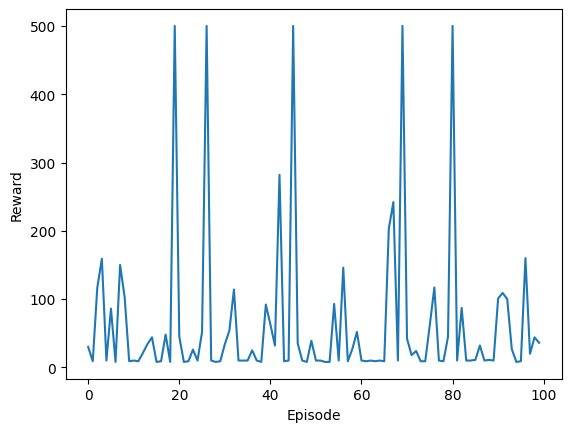

In [57]:
show_reward(total_rewards)

In [49]:
# Now run on best weight
!rm -r /content/video
env = create_env("CartPole-v1", 'rgb_array')
total_rewards = []
n_episodes = 100
weight = best_wieght

for episode in range(n_episodes):
    total_reward = run_episode(env, weight)
    total_rewards.append(total_reward)

    if total_reward > best_total_reward:
        print(f"Episode {episode} total reward: {total_reward}")
        best_total_reward = total_reward
        best_wieght = weight

avg_tot_reward = sum(total_rewards) / n_episodes
print(f"Average total reward over {n_episodes} episodes: {avg_tot_reward}")

Average total reward over 100 episodes: 500.0


In [54]:
display_video(27)

### Developing **the hill climbing algorithm**
As we can see in the random searc policy each episode is independent. and eventually the weight with the best performance will be selected.

a hill-climbing algorithm, transfer the knowledge acquired in one episode to the next episode

we also start with a randomly chosen weight. But here, for every episode we add some noise the weight, If the total reward improves we update the weight with the new one, otherwise, we keep the old one

In [59]:
# use best_weight from previous run
!rm -r /content/video
env = create_env("CartPole-v1", 'rgb_array')

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
total_rewards = []
n_episodes = 100
noise_scale = 0.01

for episode in range(n_episodes):
    weight = best_wieght + noise_scale * torch.rand((n_state, n_action))
    total_reward = run_episode(env, weight)
    total_rewards.append(total_reward)

    if total_reward > best_total_reward:
        print(f"Episode {episode} total reward: {total_reward}")
        best_total_reward = total_reward
        best_wieght = weight

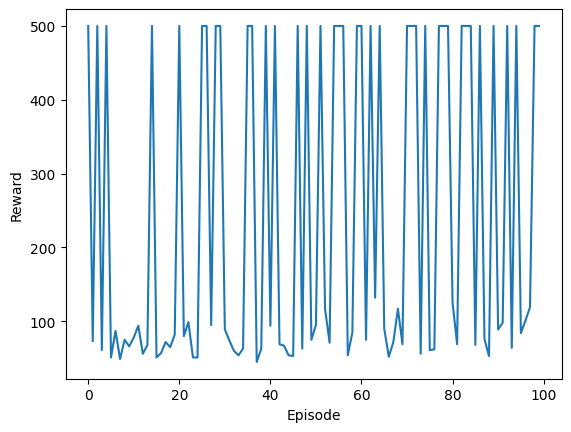

In [60]:
show_reward(total_rewards)

#### **make noise adaptive**
1. specify a starting noise
2. if the performance in the improves, decrease the noise scale. if the peroformance in the episode drop we increase the noise scale

In [63]:
# use best_weight from previous run
!rm -r /content/video
env = create_env("CartPole-v1", 'rgb_array')

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
total_rewards = []
best_total_reward = 0
n_episodes = 100
noise_scale = 0.01

for episode in range(n_episodes):
    weight = best_wieght + noise_scale * torch.rand((n_state, n_action))
    total_reward = run_episode(env, weight)
    total_rewards.append(total_reward)

    if total_reward > best_total_reward:
        print(f"Episode {episode} total reward: {total_reward}")
        best_total_reward = total_reward
        best_wieght = weight
        noise_scale = max(noise_scale / 2, 1e-4)
    else:
        noise_scale = min(noise_scale * 2, 2)

Episode 0 total reward: 68.0
Episode 1 total reward: 500.0


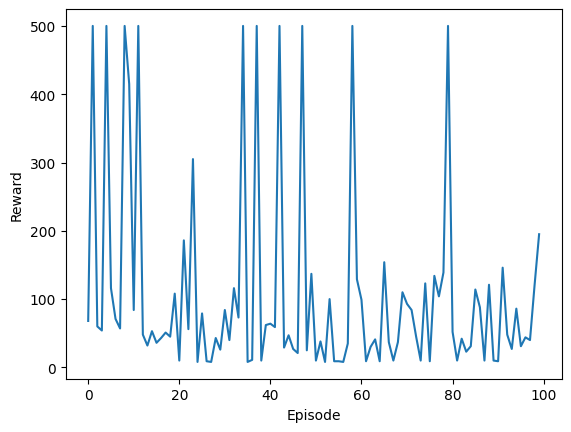

In [64]:
show_reward(total_rewards)